# Livrable 2

## 1. Introduction

Dans le cadre du projet Leyenda, dont l'objectif est de réaliser un modèle de DeepLearning permettant de faire du captionning, c'est à dire de créer un texte à partir d'une image. Ce livrable se concentre sur une étape cruciale du prétraitement des images : le débruitage. 

Le bruit numérique, qui peut résulter de diverses sources telles que des erreurs de capteurs ou des conditions de numérisation sous-optimales, affecte la qualité des images. Ce bruit altère les performances des algorithmes de traitement d'images en ajoutant des informations non désirées qui peuvent perturber l'analyse. Il est donc essentiel de débruiter ces images avant de les soumettre à d'autres algorithmes de classification ou de reconnaissance d'images.

Dans cette phase, nous utiliserons des **auto-encodeurs à convolution** pour réaliser un débruitage efficace. Ces réseaux de neurones profonds sont particulièrement adaptés au traitement d'images grâce à leur capacité à capturer les caractéristiques spatiales de l'image. Le notebook documente chaque étape du processus, depuis le chargement des images, jusqu'à leur traitement et l'évaluation des performances du modèle.


## 2. Importation et exploration des données

Avant de procéder au traitement des images, il est essentiel de configurer l'environnement en important les bibliothèques nécessaires. Cette section se concentre sur l'importation des modules et packages requis pour l'analyse et le traitement des images, ainsi que sur la configuration initiale. Nous importons également les données sous forme d'images, que nous explorerons avant d'entamer le processus de débruitage.

### 2.1. Code d'importation

In [2]:
import warnings, os, datetime, zipfile, tqdm, gdown, glob, pytz
import matplotlib.pyplot as plt
import tensorflow as tf
import wandb
from wandb.integration.lightgbm import wandb_callback

warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning)

### 2.2. Configuration des chemins et des paramètres

Dans cette section, nous configurons les chemins vers les répertoires de données et les modèles, ainsi que plusieurs paramètres essentiels pour l'entraînement du modèle.

In [47]:
timezone = pytz.timezone('Europe/Paris')
now = datetime.datetime.now(timezone).strftime('%Y.%m.%d-%H.%M.%S')

project_path = os.getcwd()

paths = {
    "data_path": f"{project_path}/data",
    "train_data_path": f"{project_path}/data/train",
    "model_path": f"{project_path}/models",
    "checkpoint_path": f"{project_path}/weights/model_early",
    "log_path": f"{project_path}/logs/fit/{now}_model"
}

for key, path in paths.items():
    os.makedirs(path, exist_ok=True)

image_h = 224
image_w = 224
batch_s = 32
epochs = 50

encoding_dim = 256

### 2.3. Téléchargement et extraction du dataset

Pour effectuer le traitement des images, il est nécessaire de télécharger et d'extraire le dataset. Le dataset est stocké dans un fichier compressé `.zip` disponible sur Google Drive. La fonction suivante télécharge ce dataset, si nécessaire, et l'extrait dans le répertoire approprié.

In [ ]:
def download_dataset(force=False):
    # Construct the dataset path
    dataset_path = os.path.join(paths['train_data_path'], 'dataset_livrable_2.zip')

    # Check if the dataset is already downloaded
    if os.path.exists(dataset_path) and not force:
        print("Dataset is already downloaded.")
    else:
        print("Downloading dataset...")
        url = 'https://drive.google.com/uc?export=download&id=190NL04KXMiUsnC-rdYDB9PLxCgk-MKuy'
        gdown.download(url, dataset_path, quiet=False)
    
    # Check if the dataset is already extracted
    if len(os.listdir(paths['train_data_path'])) == 2 and not force:
        print("Dataset is already extracted.")
    else:
        print("Extracting dataset...")
        with zipfile.ZipFile(dataset_path, 'r') as zip_ref:
            files = zip_ref.infolist()
            with tqdm.tqdm(total=len(files), desc="Extracting", unit="file") as pbar:
                for file in files:
                    zip_ref.extract(file, paths['train_data_path'])
                    pbar.update(1)
            print(f"Dataset extracted to {paths['train_data_path']}")
        
download_dataset()

### 2.4. Vérification de l'intégrité des images dans le dataset

Il est essentiel de s'assurer que les images du dataset sont valides avant de les utiliser pour l'entraînement d'un modèle. Cette section présente la fonction `check_images_in_dataset` qui permet de vérifier l'intégrité de chaque image et de supprimer les fichiers corrompus ou non valides.

In [ ]:
def check_images_in_dataset(dataset_path):
    # Get the paths of all image files (jpg, png, etc.)
    img_paths = glob.glob(os.path.join(dataset_path, '*/*.*'))

    for img_path in tqdm.tqdm(img_paths, desc="Checking images"):
        try:
            # Read and decode the image to check if it is valid
            img_bytes = tf.io.read_file(img_path)
            tf.io.decode_image(img_bytes)

        except tf.errors.InvalidArgumentError as e:
            # Catch specific TensorFlow error and remove bad files
            print(f"Found corrupt image: {img_path}. Error: {str(e)}. Removing it.")
            os.remove(img_path)
        except Exception as e:
            # General exception handler for other possible issues
            print(f"Error processing image: {img_path}. Error: {str(e)}. Removing it.")
            os.remove(img_path)

check_images_in_dataset(paths['train_data_path'])

### 2.5. Chargement et division des images en ensembles d'entraînement et de test

Dans cette section, nous chargeons les images du dataset et les divisons en deux sous-ensembles : l'un pour l'entraînement (80%) et l'autre pour la validation (20%). Cette étape est cruciale pour entraîner le modèle sur une partie des données tout en réservant une portion pour évaluer ses performances.

In [ ]:
# Load and split images into train and test sets (80%-20%)
train_set, validation_set = tf.keras.utils.image_dataset_from_directory(
    paths['train_data_path'],
    validation_split=0.2,
    subset="both",
    seed=42,
    image_size=(image_h, image_w),
    batch_size=batch_s,
    labels=None,
    label_mode=None
)

### 2.6. Prétraitement des images : Ajout de bruit gaussien et redimensionnement

Dans cette phase, nous ajoutons une couche de redimensionnement pour normaliser les valeurs des pixels des images et appliquons un bruit gaussien à chaque lot d'images. Ce bruit simule des perturbations réelles présentes dans des images de mauvaise qualité, comme celles numérisées avec des artefacts, afin d'entraîner un modèle capable de restaurer des images bruitées.

In [51]:
# Adding the resizing layer
rescale_layer = tf.keras.layers.Rescaling(1./255)

# Adds Gaussian noise to images, keeping pixel values in [0, 1].
def add_gaussian_noise(images, min_noise=0.1, max_noise=0.5):
    batch_size = tf.shape(images)[0]
    noise_factor = tf.random.uniform(shape=(batch_size, 1, 1, 1), minval=min_noise, maxval=max_noise)
    noise = tf.random.normal(shape=tf.shape(images))
    noisy_images = images + noise_factor * noise
    noisy_images = tf.clip_by_value(noisy_images, 0.0, 1.0)
    return noisy_images

noisy_train_set = train_set.map(
    lambda x: (add_gaussian_noise(rescale_layer(x)), rescale_layer(x)),
    num_parallel_calls=tf.data.AUTOTUNE
).cache().prefetch(buffer_size=tf.data.AUTOTUNE)

noisy_validation_set = validation_set.map(
    lambda x: (add_gaussian_noise(rescale_layer(x)), rescale_layer(x)),
    num_parallel_calls=tf.data.AUTOTUNE
).cache().prefetch(buffer_size=tf.data.AUTOTUNE)

### 2.7. Visualisation des images originales et bruitées

La visualisation est une étape importante pour s'assurer que le bruit est correctement appliqué aux images d'entraînement et pour comparer les images d'origine avec leurs versions bruitées. La fonction `display_noisy_train_images` permet d'afficher côte à côte un échantillon d'images originales et bruitées à partir du dataset d'entraînement.

In [ ]:
# Function for displaying original and noisy images
def display_noisy_train_images(noisy_dataset, num_images=5):
    plt.figure(figsize=(15, 6))

    for noisy_images, original_images in noisy_dataset.take(1):
        for i in range(num_images):
            # Original pictures
            plt.subplot(2, num_images, i + 1)
            plt.imshow(original_images[i].numpy())
            plt.title('Original')
            plt.axis('off')

            # Noisy images
            plt.subplot(2, num_images, num_images + i + 1)
            plt.imshow(noisy_images[i].numpy())
            plt.title('Noisy')
            plt.axis('off')

    plt.tight_layout()
    plt.show()

display_noisy_train_images(noisy_train_set, num_images=5)

## 3. Construction de l'Auto-encodeur

Un auto-encodeur est un type de réseau de neurones utilisé pour apprendre une représentation compacte (encodée) des données en entrée. Il est constitué de deux parties principales : l'encodeur et le décodeur. L'encodeur réduit les dimensions des données d'entrée, tandis que le décodeur tente de reconstruire les données originales à partir de cette représentation réduite. Ce modèle est particulièrement utile pour des tâches comme le débruitage d'images.

### Explication générale : Comment fonctionne un auto-encodeur ?

Un auto-encodeur prend une image en entrée et passe par plusieurs couches pour compresser l'image en une représentation latente plus petite. Ensuite, cette représentation compressée est passée à travers le décodeur, qui reconstruit l'image. L'objectif du modèle est de minimiser la différence entre l'image d'origine et l'image reconstruite, ce qui signifie qu'il apprend à capturer les caractéristiques importantes de l'image tout en éliminant le bruit ou d'autres détails inutiles.

Le modèle d'auto-encodeur est optimisé avec une fonction de perte telle que l'erreur quadratique moyenne (MSE) pour comparer les pixels de l'image originale à ceux de l'image reconstruite.

### 3.1. Construction de l'Auto-encodeur

In [ ]:
def build_autoencoder(input_shape, activation_function, dropout_rate):

    input_img = tf.keras.layers.Input(shape=input_shape)

    # Encoder
    x = tf.keras.layers.Conv2D(32, (3, 3), activation=activation_function, padding='same')(input_img)
    x = tf.keras.layers.MaxPooling2D((2, 2), padding='same')(x)
    x = tf.keras.layers.Dropout(dropout_rate)(x)

    x = tf.keras.layers.Conv2D(64, (3, 3), activation=activation_function, padding='same')(x)
    x = tf.keras.layers.MaxPooling2D((2, 2), padding='same')(x)
    x = tf.keras.layers.Dropout(dropout_rate)(x)

    x = tf.keras.layers.Conv2D(128, (3, 3), activation=activation_function, padding='same')(x)
    x = tf.keras.layers.Dropout(dropout_rate)(x)

    encoded = tf.keras.layers.MaxPooling2D((2, 2), padding='same')(x)

    # Decoder
    x = tf.keras.layers.Conv2D(128, (3, 3), activation=activation_function, padding='same')(encoded)
    x = tf.keras.layers.UpSampling2D((2, 2))(x)

    x = tf.keras.layers.Conv2D(64, (3, 3), activation=activation_function, padding='same')(x)
    x = tf.keras.layers.UpSampling2D((2, 2))(x)

    x = tf.keras.layers.Conv2D(32, (3, 3), activation=activation_function, padding='same')(x)
    x = tf.keras.layers.UpSampling2D((2, 2))(x)

    decoded = tf.keras.layers.Conv2D(3, (3, 3), activation=activation_function, padding='same')(x)

    # Self-encoding model
    autoencoder = tf.keras.Model(input_img, decoded)
    return autoencoder


### 3.2. Explication du modèle couche par couche

#### 1. **Encodeur** 

L'encodeur est responsable de la compression des données d'entrée en une représentation plus compacte. Cela se fait à l'aide de couches convolutives et de pooling pour réduire les dimensions tout en capturant les caractéristiques importantes de l'image.

- **Première couche Conv2D :**
  - **Type de couche** : Convolution 2D
  - **Nombre de filtres** : 32 filtres
  - **Taille du noyau (kernel)** : (3, 3)
  - **Fonction d'activation** : ReLU
  - **Padding** : `same` (cela conserve les dimensions d'entrée)
  - **Rôle** : Appliquer 32 filtres de convolution pour extraire des caractéristiques basiques des images (bords, textures).

- **MaxPooling2D :**
  - **Type de couche** : Pooling (sous-échantillonnage)
  - **Taille du pool** : (2, 2)
  - **Padding** : `same` (cela conserve les dimensions tout en réduisant la résolution)
  - **Rôle** : Réduit la taille de l'image de moitié, en prenant la valeur maximale dans chaque fenêtre de 2x2 pixels, tout en préservant les caractéristiques les plus saillantes.

- **Deuxième couche Conv2D :**
  - **Nombre de filtres** : 64 filtres
  - **Taille du noyau** : (3, 3)
  - **Fonction d'activation** : ReLU
  - **Padding** : `same`
  - **Rôle** : Augmenter la profondeur des caractéristiques extraites avec 64 filtres, capturant ainsi des détails plus complexes.

- **MaxPooling2D :**
  - Identique à la première couche de MaxPooling2D, cette couche réduit encore la résolution tout en conservant les caractéristiques importantes.

- **Troisième couche Conv2D :**
  - **Nombre de filtres** : 128 filtres
  - **Taille du noyau** : (3, 3)
  - **Fonction d'activation** : ReLU
  - **Padding** : `same`
  - **Rôle** : Extraire des caractéristiques encore plus fines avec plus de filtres, capturant des structures détaillées de l'image.

- **MaxPooling2D (encoded layer)** :
  - Cette couche finale de MaxPooling dans l'encodeur réduit encore l'image pour obtenir la représentation encodée. C'est la sortie compressée de l'image, appelée "représentation latente". Elle a une dimension beaucoup plus petite, mais conserve les informations essentielles nécessaires à la reconstruction.

#### 2. **Décodeur**

Le décodeur est la partie qui prend la représentation encodée et tente de reconstruire l'image d'origine. Il utilise des couches convolutives et d'up-sampling pour restaurer les dimensions de l'image à partir de la représentation latente.

- **Première couche Conv2D :**
  - **Nombre de filtres** : 128 filtres
  - **Taille du noyau** : (3, 3)
  - **Fonction d'activation** : ReLU
  - **Padding** : `same`
  - **Rôle** : Commence le processus de reconstruction de l'image avec les mêmes caractéristiques extraites par la dernière couche de convolution de l'encodeur.

- **UpSampling2D :**
  - **Type de couche** : Upsampling (sur-échantillonnage)
  - **Taille de la fenêtre** : (2, 2)
  - **Rôle** : Double les dimensions de l'image à chaque étape pour restaurer la résolution originale, inversant l'effet de MaxPooling.

- **Deuxième couche Conv2D :**
  - Identique à la précédente, mais avec 64 filtres, réduisant progressivement la complexité des caractéristiques au fur et à mesure que l'on s'approche de l'image reconstruite.

- **UpSampling2D :**
  - Identique à la première couche d'UpSampling, elle augmente encore les dimensions de l'image.

- **Troisième couche Conv2D :**
  - **Nombre de filtres** : 32 filtres
  - **Taille du noyau** : (3, 3)
  - **Fonction d'activation** : ReLU
  - **Padding** : `same`
  - **Rôle** : Applique des filtres moins complexes pour affiner la reconstruction de l'image.

- **UpSampling2D :**
  - Effectue une dernière opération de sur-échantillonnage pour restaurer l'image à sa taille originale.

- **Dernière couche Conv2D :**
  - **Nombre de filtres** : 3 (correspondant aux 3 canaux de couleur RGB)
  - **Taille du noyau** : (3, 3)
  - **Fonction d'activation** : Sigmoïde
  - **Padding** : `same`
  - **Rôle** : Reconstituer les valeurs de pixels de l'image reconstruite dans l'intervalle [0, 1].

#### 3. **Compilation du modèle**

Une fois le modèle créé, il est compilé avec les paramètres suivants :
- **Optimiseur** : `adam` — Un optimiseur populaire basé sur la descente de gradient adaptative.
- **Fonction de perte** : `mean squared error (mse)` — Calcul la différence entre l'image originale et l'image reconstruite pixel par pixel.

### 3.3. Configuration des callbacks pour l'entraînement du modèle

Les callbacks permettent d'automatiser et d'optimiser l'entraînement du modèle en surveillant les performances, en sauvegardant les poids et en stoppant l'entraînement en cas de stagnation. La fonction ``get_callbacks()`` regroupe quatre callbacks essentiels :

- **Sauvegarde des checkpoints :** Le callback ``ModelCheckpoint`` enregistre les poids du modèle à chaque amélioration de la perte de validation (``val_loss``). Cela permet de conserver la meilleure version du modèle.

- **Suivi avec TensorBoard :** Le callback TensorBoard génère des logs pour visualiser l'évolution des métriques, le graphe du modèle et les images des données. C'est un outil de suivi visuel très utile.

- **Arrêt anticipé (EarlyStopping) :** Ce callback stoppe l'entraînement si la perte de validation cesse de s'améliorer pendant 5 époques, évitant ainsi le surentraînement et optimisant la durée d'entraînement.

- **Suivi en temps réel avec WandB :** Le callback WandbMetricsLogger enregistre les métriques dans Weights & Biases (WandB), facilitant la visualisation et le suivi des performances du modèle en temps réel.

In [4]:
def get_callbacks():
    # Create a callback that saves the model's weights at each epoch where validation loss improves
    checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
        filepath=paths['checkpoint_path'] + "/weights-epoch-{epoch:02d}-{val_loss:.2f}.weights.h5",
        save_weights_only=True,
        save_best_only=True,
        verbose=1
    )

    # Create a TensorBoard callback to log training metrics, model graphs, and images for visualization
    tensorboard_callback = tf.keras.callbacks.TensorBoard(
        log_dir=paths['log_path'],
        histogram_freq=1,
        write_graph=True,
        write_images=True,
        update_freq='epoch',
        profile_batch=0,
        embeddings_freq=0
    )

    # Set up early stopping to halt training if validation loss stops improving for a set number of epochs
    early_callback = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        min_delta=0,
        patience=5,
        verbose=0,
        mode='auto',
        baseline=None,
        restore_best_weights=True,
        start_from_epoch=0
    )

    # Wandb callback
    wandb_callback = wandb.keras.WandbMetricsLogger()

    return [
        checkpoint_callback,
        tensorboard_callback,
        early_callback,
        wandb_callback
    ]

### 3.4 Plan d'Expériences avec Weights & Biases (Wandb)

Pour optimiser les performances de notre autoencodeur, nous avons mis en place un **plan d'expériences** structuré à l'aide de **Wandb Sweep**. L'objectif est d'explorer systématiquement différentes configurations d'hyperparamètres afin de déterminer la combinaison optimale qui maximise les performances du modèle.

L'optimisation des hyperparamètres est cruciale pour améliorer la précision, accélérer la convergence et renforcer la capacité de généralisation du modèle. Nous avons opté pour une approche d'optimisation bayésienne, qui, contrairement aux méthodes de recherche par grille ou aléatoire, utilise les résultats des expériences précédentes pour guider les sélections futures d'hyperparamètres. Cela permet de réduire le nombre total d'itérations nécessaires tout en améliorant l'efficacité de la recherche.

#### 1. Définition du Plan d'Expériences

Le plan d'expériences est défini par un ensemble d'hyperparamètres que nous souhaitons optimiser. Le code suivant établit la configuration du sweep avec des valeurs spécifiques pour chaque hyperparamètre :

In [ ]:
sweep_config = {
    'method': 'bayes',
    'metric': {
        'name': 'val_loss',
        'goal': 'minimize'
    },
    'parameters': {
        'learning_rate': {
            'values': [0.001, 0.0001, 0.00001]
        },
        'batch_size': {
            'values': [32, 64, 128]
        },
        'optimizer': {
            'values': ['adam', 'sgd', 'rmsprop']
        },
        'dropout_rate': {
            'values': [0.0, 0.2, 0.5]
        },
        'activation_function': {
            'values': ['relu', 'tanh', 'sigmoid']
        }
    }
}

Les hyperparamètres considérés dans ce plan d'expériences sont les suivants :

- **Taux d'apprentissage (learning rate)** : Paramètre essentiel influençant la vitesse de convergence du modèle. Nous testons des taux de 0.001, 0.0001 et 0.00001 pour observer comment le modèle ajuste ses poids au cours de l'entraînement.

- **Taille des lots (batch size)** : La taille du lot affecte la stabilité et la rapidité de l'apprentissage. Des lots plus petits peuvent favoriser une meilleure généralisation, mais nécessitent davantage d'itérations pour une mise à jour complète des poids.

- **Optimiseur** : Nous évaluons trois optimiseurs — `adam`, `sgd` et `rmsprop` — chacun ayant des propriétés distinctes en termes de vitesse de convergence et de stabilité.

- **Taux de dropout** : Le dropout est utilisé pour la régularisation en désactivant aléatoirement une fraction des neurones pendant l'entraînement, ce qui aide à prévenir le surapprentissage. Nous testons des valeurs de 0.0, 0.2 et 0.5.

- **Fonction d'activation** : Les fonctions d'activation introduisent de la non-linéarité dans le modèle, essentielle pour l'apprentissage de représentations complexes. Nous testons les fonctions `relu`, `tanh` et `sigmoid`.

#### 2. Entraînement du Modèle et Optimisation avec Wandb Sweep

La fonction suivante, `train_model`, est utilisée pour entraîner l'autoencodeur avec les hyperparamètres sélectionnés par Wandb Sweep. Cette fonction prend en entrée les hyperparamètres, construit et compile le modèle, puis l'entraîne sur les ensembles de données d'entraînement et de validation bruités.

In [ ]:
def train_model(config=None):
    # Initialize W&B run
    wandb.init(config=config)

    # Use the config to set hyperparameters
    optimizer = wandb.config.optimizer
    learning_rate =  wandb.config.learning_rate
    batch_size =  wandb.config.batch_size
    activation_function =  wandb.config.activation_function
    dropout_rate =  wandb.config.dropout_rate

    noisy_train_set = train_set.map(
        lambda x: (add_gaussian_noise(rescale_layer(x)), rescale_layer(x)),
        num_parallel_calls=tf.data.AUTOTUNE
    ).cache().prefetch(buffer_size=tf.data.AUTOTUNE)

    # Adds Gaussian noise and rescales the test set images, optimizing with parallel processing.
    noisy_test_set = validation_set.map(
        lambda x: (add_gaussian_noise(rescale_layer(x)), rescale_layer(x)),
        num_parallel_calls=tf.data.AUTOTUNE
    ).cache().prefetch(buffer_size=tf.data.AUTOTUNE)


    # Build and compile the autoencoder model
    autoencoder = build_autoencoder((image_h, image_w, 3), activation_function, dropout_rate)
    if optimizer == 'adam':
        optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    elif optimizer == 'sgd':
        optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)
    elif optimizer == 'rmsprop':
        optimizer = tf.keras.optimizers.RMSprop(learning_rate=learning_rate)

    autoencoder.compile(optimizer=optimizer, loss='mse')

    # Train the model
    history = autoencoder.fit(
        noisy_train_set,
        validation_data=noisy_test_set,
        batch_size=batch_size,
        epochs=10,
        callbacks=get_callbacks()
    )

    wandb.log({"val_loss": history.history['val_loss'][-1]})

    return history


#### 3. Lancement du Wandb Sweep

Une fois la fonction d'entraînement définie, nous lançons le **Wandb Sweep** pour exécuter jusqu'à 100 expériences avec différentes combinaisons d'hyperparamètres. Chaque expérience entraîne le modèle avec une configuration unique, et les résultats sont automatiquement enregistrés pour analyse et comparaison.

In [ ]:
sweep_id = wandb.sweep(sweep_config, project='livrable_2')

wandb.agent(sweep_id, train_model, count=100)

wandb.finish()

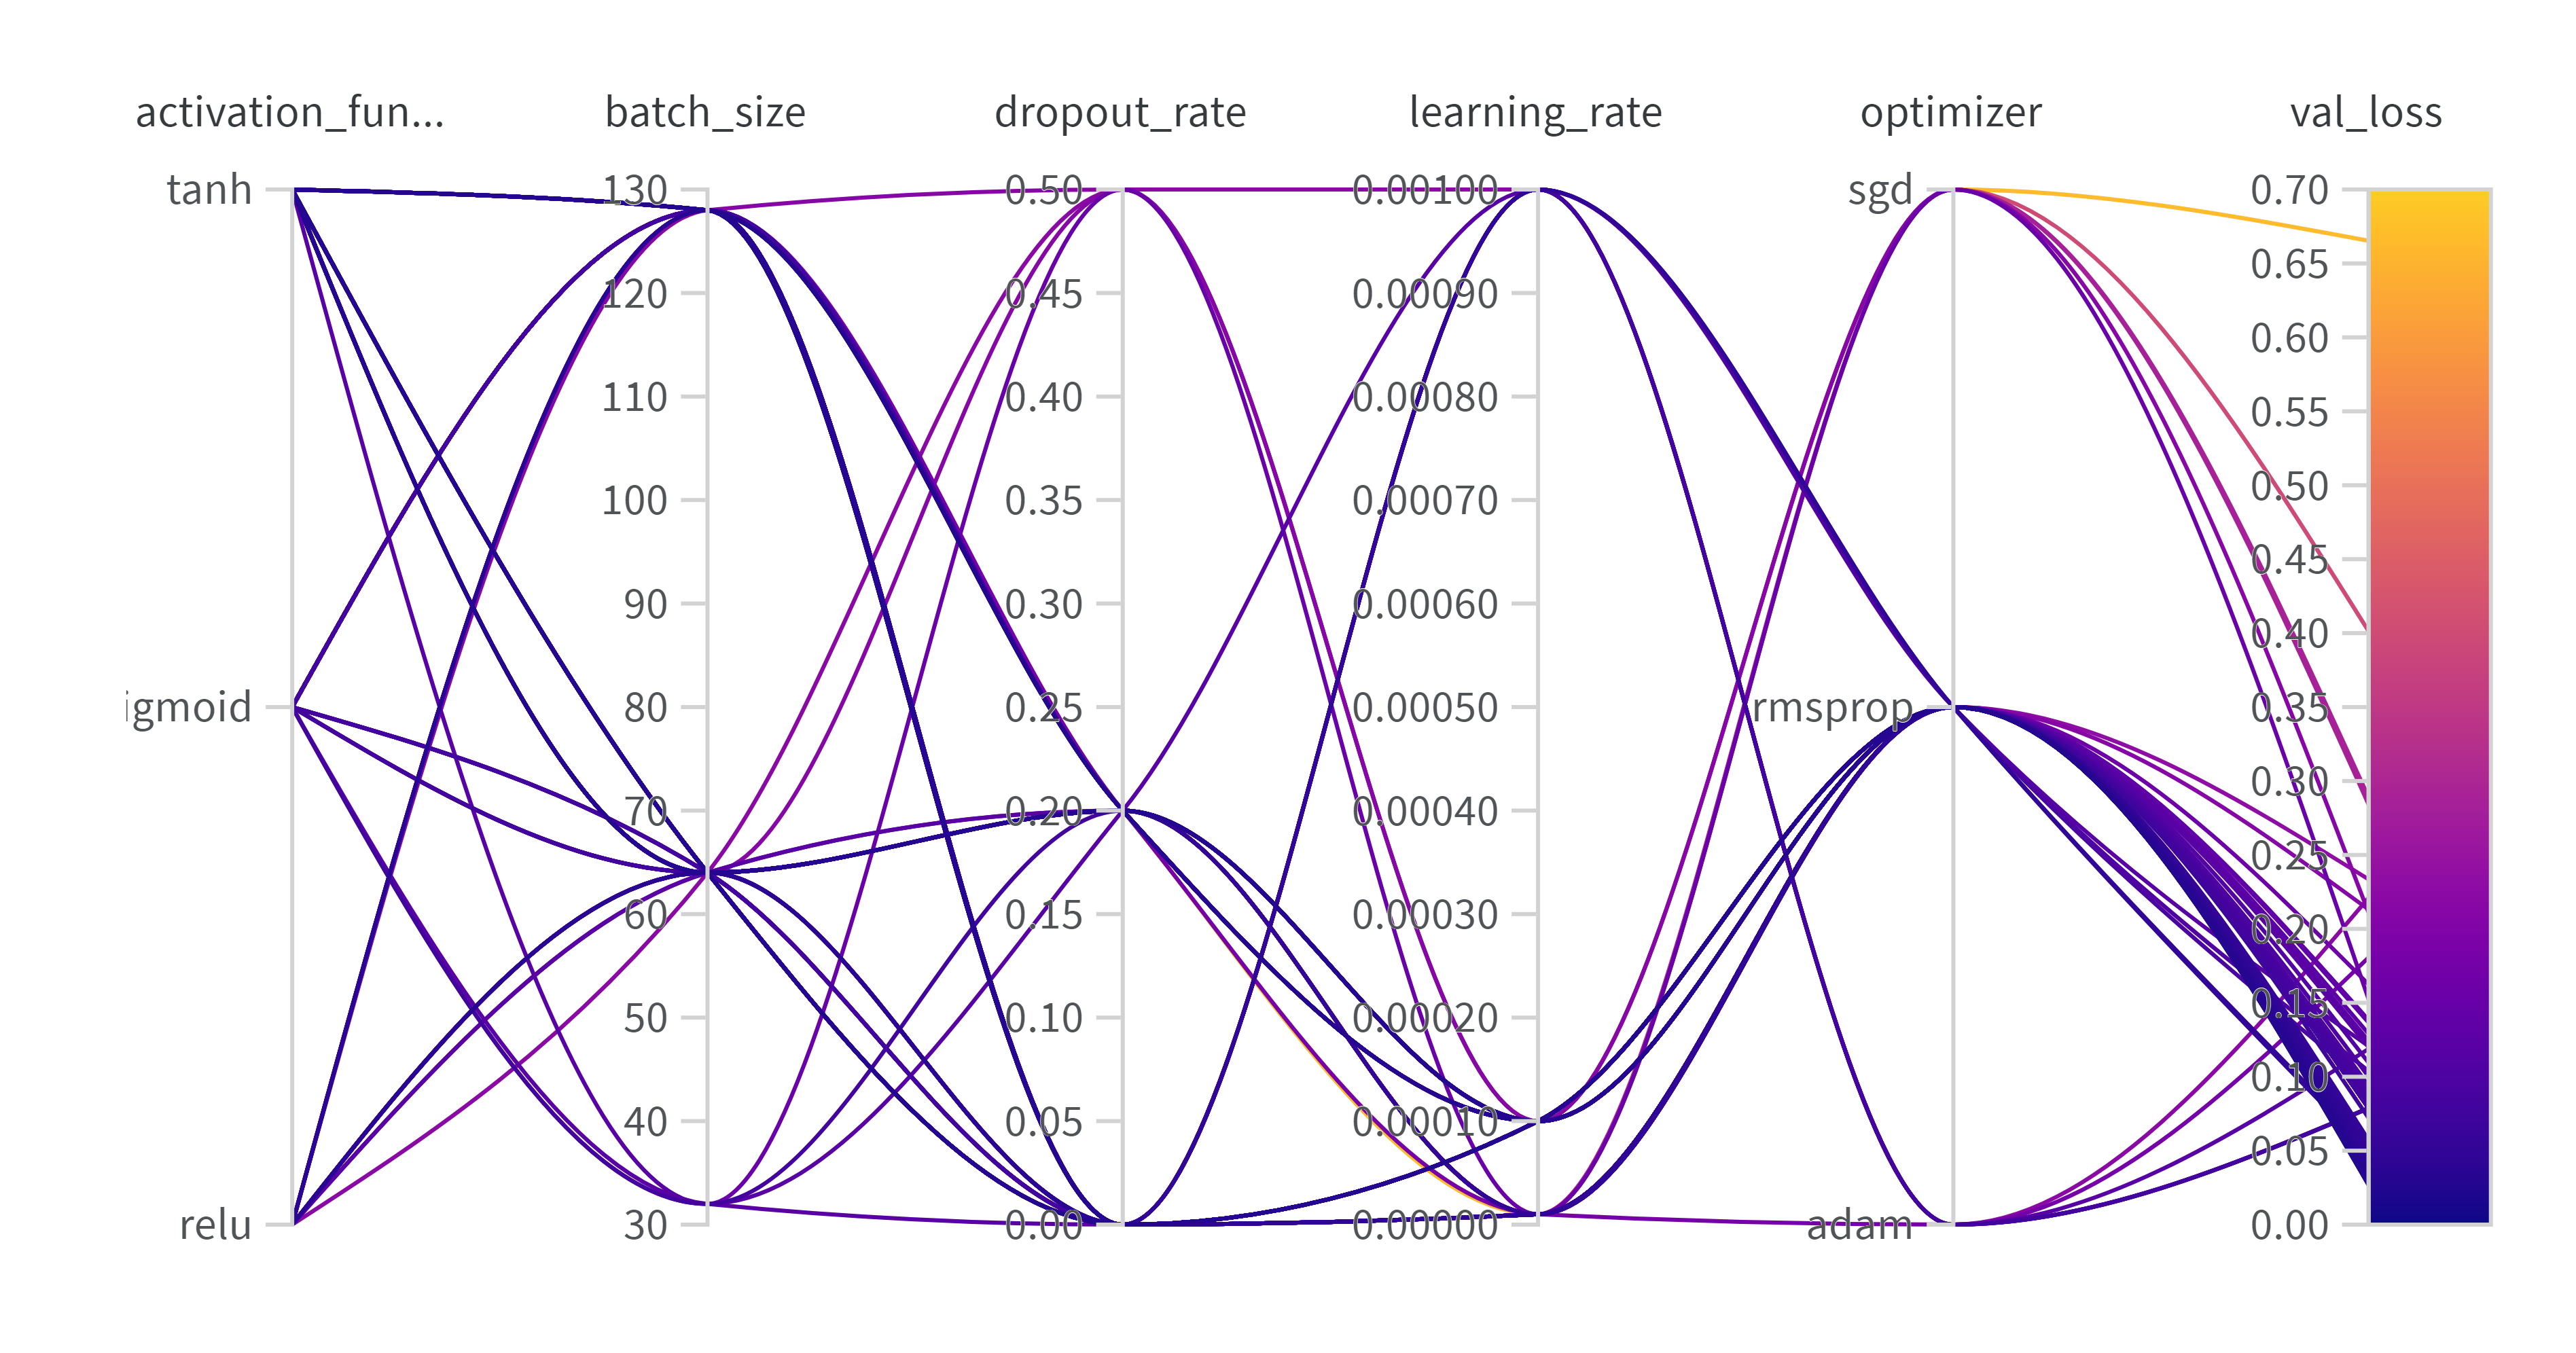

### 4. Analyse des Hyperparamètres avec un Graphique Parallèle

#### Visualisation des Résultats avec un Graphique Parallèle

Afin d'analyser les performances de notre modèle en fonction des différentes combinaisons d'hyperparamètres, nous utilisons un **graphique parallèle**. Ce type de graphique est particulièrement utile pour visualiser les relations entre plusieurs variables et identifier les meilleures configurations d'hyperparamètres en termes de performance.

Le graphique que nous avons généré présente les résultats du **sweep Wandb** réalisé avec différentes combinaisons d'hyperparamètres, en traçant leur relation avec la **perte de validation (val_loss)**. Chaque ligne du graphique correspond à une expérience unique avec une combinaison donnée d'hyperparamètres, et la couleur de la ligne reflète la performance de cette configuration.

#### Lecture du Graphique Parallèle

Le graphique est composé de plusieurs axes verticaux, chacun représentant un hyperparamètre différent :
- **Activation function** : Les fonctions d'activation utilisées dans l'autoencodeur, telles que `sigmoid`, `tanh`, et `relu`.
- **Batch size** : La taille des lots, qui détermine combien d'exemples sont passés à travers le réseau avant la mise à jour des poids.
- **Dropout rate** : Le taux de dropout, qui représente la fraction de neurones ignorés durant l'entraînement pour éviter le surapprentissage.
- **Learning rate** : Le taux d'apprentissage, qui détermine la rapidité avec laquelle le modèle ajuste ses poids.
- **Optimizer** : L'optimiseur utilisé, parmi `adam`, `sgd` et `rmsprop`.
- **Validation Loss (val_loss)** : Le dernier axe du graphique représente la **perte de validation**, qui est l'objectif que nous cherchons à minimiser.

Les **lignes** du graphique traversent chaque axe et représentent une configuration unique d'hyperparamètres testée. Chaque ligne passe par une valeur spécifique sur chaque axe, montrant la configuration choisie pour cette expérience.

#### Couleurs et Interprétation

Les **couleurs** des lignes dans le graphique sont essentielles pour comprendre les performances des modèles :
- Les lignes **violettes** représentent des combinaisons d'hyperparamètres ayant une faible perte de validation, ce qui indique une bonne performance du modèle.
- Les lignes **jaunes** et **oranges** représentent des combinaisons d'hyperparamètres avec des pertes de validation plus élevées, indiquant des performances moins bonnes.

L'objectif est d'identifier les lignes les plus violettes, car elles correspondent aux combinaisons d'hyperparamètres qui minimisent la perte de validation.

#### Sélection des Meilleurs Hyperparamètres

En examinant les lignes violettes, nous pouvons déduire les hyperparamètres qui mènent aux meilleures performances :
- **Fonction d'activation** : La fonction **sigmoid** a produit des lignes plus violettes, ce qui suggère qu'elle donne de bonnes performances en termes de reconstruction d'images.
- **Batch size** : Une **taille de lot de 32** est souvent associée aux lignes violettes, ce qui suggère que c'est un bon compromis entre stabilité et vitesse d'entraînement.
- **Dropout rate** : Un **taux de dropout de 0.0** a montré les meilleures performances, suggérant que la régularisation par dropout n'est pas nécessaire dans ce cas.
- **Learning rate** : Un **taux d'apprentissage de 0.0001** est optimal, permettant au modèle de converger lentement mais de manière stable.
- **Optimizer** : L'optimiseur **RMSprop** semble être le meilleur choix, car il est souvent associé aux lignes violettes.

#### Conclusion

Le graphique parallèle nous a permis d'analyser visuellement l'impact des différentes combinaisons d'hyperparamètres sur les performances du modèle. Sur la base de cette analyse, nous avons sélectionné les hyperparamètres suivants comme étant les meilleurs pour notre autoencodeur :
- **Fonction d'activation** : Sigmoid
- **Batch size** : 32
- **Dropout rate** : 0.0
- **Learning rate** : 0.0001
- **Optimizer** : RMSprop

Ces hyperparamètres ont produit les meilleures performances avec une perte de validation minimale, et seront utilisés pour entraîner le modèle final.

In [ ]:
final_autoencoder = build_autoencoder((image_h, image_w, 3), "sigmoid", 0)
optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.0001)
final_autoencoder.compile(optimizer=optimizer, loss='mse')
history = final_autoencoder.fit(
        noisy_train_set,
        validation_data=noisy_validation_set,
        batch_size=32,
        epochs=50,
        callbacks=get_callbacks()
    )

### 5. Comparaison
La fonction `display_denoised_images` sert à visualiser les résultats du modèle de débruitage. Elle commence par créer une figure avec plt.figure(figsize=(15, 8)) pour définir l'affichage. Ensuite, elle extrait un lot d'images bruyantes et leurs images originales du dataset via for noisy_images, original_images in dataset.take(1).

La fonction prédit les images débruitées à l'aide du modèle, puis affiche trois versions pour chaque image : la version bruitée, la version débruitée et la version originale. Enfin, elle ajuste l'espacement des sous-figures et affiche le tout avec plt.show(). Cela permet de comparer visuellement les performances du modèle.

In [ ]:
def display_denoised_images(model, dataset, num_images=5):
    plt.figure(figsize=(15, 8))

    for noisy_images, original_images in dataset.take(1):
        # Predicting denoised pictures
        denoised_images = model.predict(noisy_images)
        
        for i in range(num_images):
            # Noisy images
            plt.subplot(3, num_images, i + 1)
            plt.imshow(noisy_images[i].numpy())
            plt.title('Noisy')
            plt.axis('off')
            
            # Denoised images
            plt.subplot(3, num_images, num_images + i + 1)
            plt.imshow(denoised_images[i])
            plt.title('Denoised')
            plt.axis('off')
            
            # Original picture
            plt.subplot(3, num_images, 2 * num_images + i + 1)
            plt.imshow(original_images[i].numpy())
            plt.title('Original')
            plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# Displaying results
display_denoised_images(final_autoencoder, noisy_validation_set, num_images=5)

### 4. Conclusion
Le projet Leyenda vise à développer une solution pour améliorer la qualité des images numérisées, facilitant ainsi leur traitement par des algorithmes de Deep Learning. L'accent est mis sur le débruitage, une étape essentielle du prétraitement, qui permet de réduire le bruit numérique résultant de divers facteurs tels que les erreurs de capteurs ou des conditions de numérisation inadaptées.

Pour atteindre cet objectif, des auto-encodeurs à convolution sont utilisés, exploitant leur capacité à capturer les caractéristiques spatiales des images tout en éliminant les informations non désirées. Le processus comprend plusieurs étapes clés, de l'importation et de l'exploration des données, à la vérification de l'intégrité des images, en passant par l'ajout de bruit gaussien pour simuler des conditions réelles.

La construction et l'entraînement d'un modèle d'auto-encodeur, optimisé à l'aide de la fonction de perte d'erreur quadratique moyenne, permettent de reconstruire des images de haute qualité à partir de leurs versions bruitées. Des callbacks sont configurés pour superviser l'entraînement et sauvegarder les meilleures performances, garantissant ainsi l'efficacité du modèle.

Les résultats de ce projet permettront d'améliorer significativement le traitement d'images par des algorithmes de classification et de reconnaissance, posant ainsi les bases pour des applications avancées dans divers domaines nécessitant une analyse d'images de qualité.